In [1]:
import os
import pickle
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd


In [34]:
# DATA PARAMETERS

survey = "HERMES" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 4000 # minimum wavelength of the data
max_wv = 4600 # maximum wavelength of the data
spec_dir = r"C:\Users\kentb\Desktop\PDM\data\Hermes\alfUMi_Hermes_spectra" # directory of the spectrum
rv_dir = r"C:\Users\kentb\Desktop\PDM\data\RV\alfUMi_rv.csv" # directory of the RVs
results_dir = r"C:\Users\kentb\Desktop\PDM\data\products\Coralie14\RCru" # directory of the results

In [37]:
obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir,find_beggining=True)
df = pd.read_csv(rv_dir)
rv = df.rv.astype(float).values
e_rv = df.rv_err.astype(float).values
times = df.bjd.astype(float).values
if survey == "CORALIE": 
    ids = df.unique_id.astype(str).values
elif survey == "HERMES":
    ids = df.unique_id.astype(int).values
    

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\data\Hermes\alfUMi_Hermes_spectra
Selected directory: C:\Users\kentb\Desktop\PDM\data\Hermes\alfUMi_Hermes_spectra


In [38]:
print(obs_data.unique_ids)
print(ids)

[836447, 836988, 838417, 838930, 839287, 840355, 841132, 841648, 848325, 848351, 848540, 849249, 849250, 850433, 850471, 850848, 851643, 895043, 895116, 895250, 895251, 895382, 895508, 895638, 895825, 895911, 902020, 902032, 902615, 902733, 903141, 903383, 913078, 913221, 913222, 913366, 913368, 913519, 999266, 999374, 999480, 999584, 999895, 1000359, 1000923, 1001357, 1001770, 1002773, 1002896, 1003148, 1003484, 1003485, 1004349, 1015022, 1015411, 1018970, 1019122, 1022101, 1022211, 1024858, 1030535, 1030558, 1030643, 1030652, 1030757, 1030873, 1030889, 1030988, 1031176, 1031360, 1031560, 1032260, 1032365, 1033075, 1035841, 1036193, 1036445, 1036756, 1037057, 1037495, 1037808, 1038684, 1040706, 1045229, 1045613, 1046136, 1046282, 1047155, 1051126, 1051219, 1051345, 1052744, 1061192, 1061287, 1061563, 1061810, 1061938, 1062237, 1063667, 1063846, 1064254, 1064474, 1064583, 1064684, 1064791, 1066070, 1066178, 1066255, 1066366, 1066450, 1066563, 1066655, 1066656, 1066771, 1066880, 1067095

In [39]:
print(len(times),len(obs_data.time_series.times))

186 150


In [40]:
# Rearrange the RVs with the spectra

obs_data.rearrange_time_series(rv=rv, times=times, ids=ids)

Matching ratio -> 30 %


In [14]:
print(type(obs_data.time_series.times))

<class 'list'>


In [28]:
obs_data.time_series.times = [i-int(min(times)) for i in obs_data.time_series.times]
times = times -int(min(times))

In [22]:
# Preprocess the spectra

for i in obs_data.time_series.vals:
    i = i.SpecPreProccess()

In [28]:
# PERIODOGRAM PARAMETERS

baseline = int(obs_data.time_series.times[-1])
min_freq = 1/62 # Or maybe 1/2/baseline to be sure but let's test it that way.
max_freq = 0.7 # we don't expect more than one pulsation every two day so should be alright.
freq_range = (min_freq, max_freq) # frequency range of the periodograms
points_per_peak = 5
periodogram_grid_resolution = 5000#points_per_peak*max_freq*baseline # frequency resolution of the periodograms

In [13]:
print("Baseline: ", baseline)

Baseline:  2458146


In [29]:
# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=freq_range,
                                        periodogram_grid_resolution=periodogram_grid_resolution)

In [30]:
obs_data.periodicity_detector.calc_GLS()

print("GLS done", flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")

print("Shape done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")

print("Shift done",flush=True)

# file = open(os.path.join(results_dir, f"{spec_dir.rsplit('/',maxsplit=1)[-1]}_{str(min_wv)}_{str(max_wv)}.pkl"), 'wb')
# pickle.dump(obs_data, file)
# file.close()

GLS done
Shape done
Shift done


In [31]:
obs_data.periodicity_detector.period_truth = [2.1390]

Shape has highest peak
Relative error on period:  11.457240521908593
Max shape peak power:  0.3657946023801213
Max shift peak power:  0.32788520910390984
Ratio of max shape to max shift:  1.1156178815745166


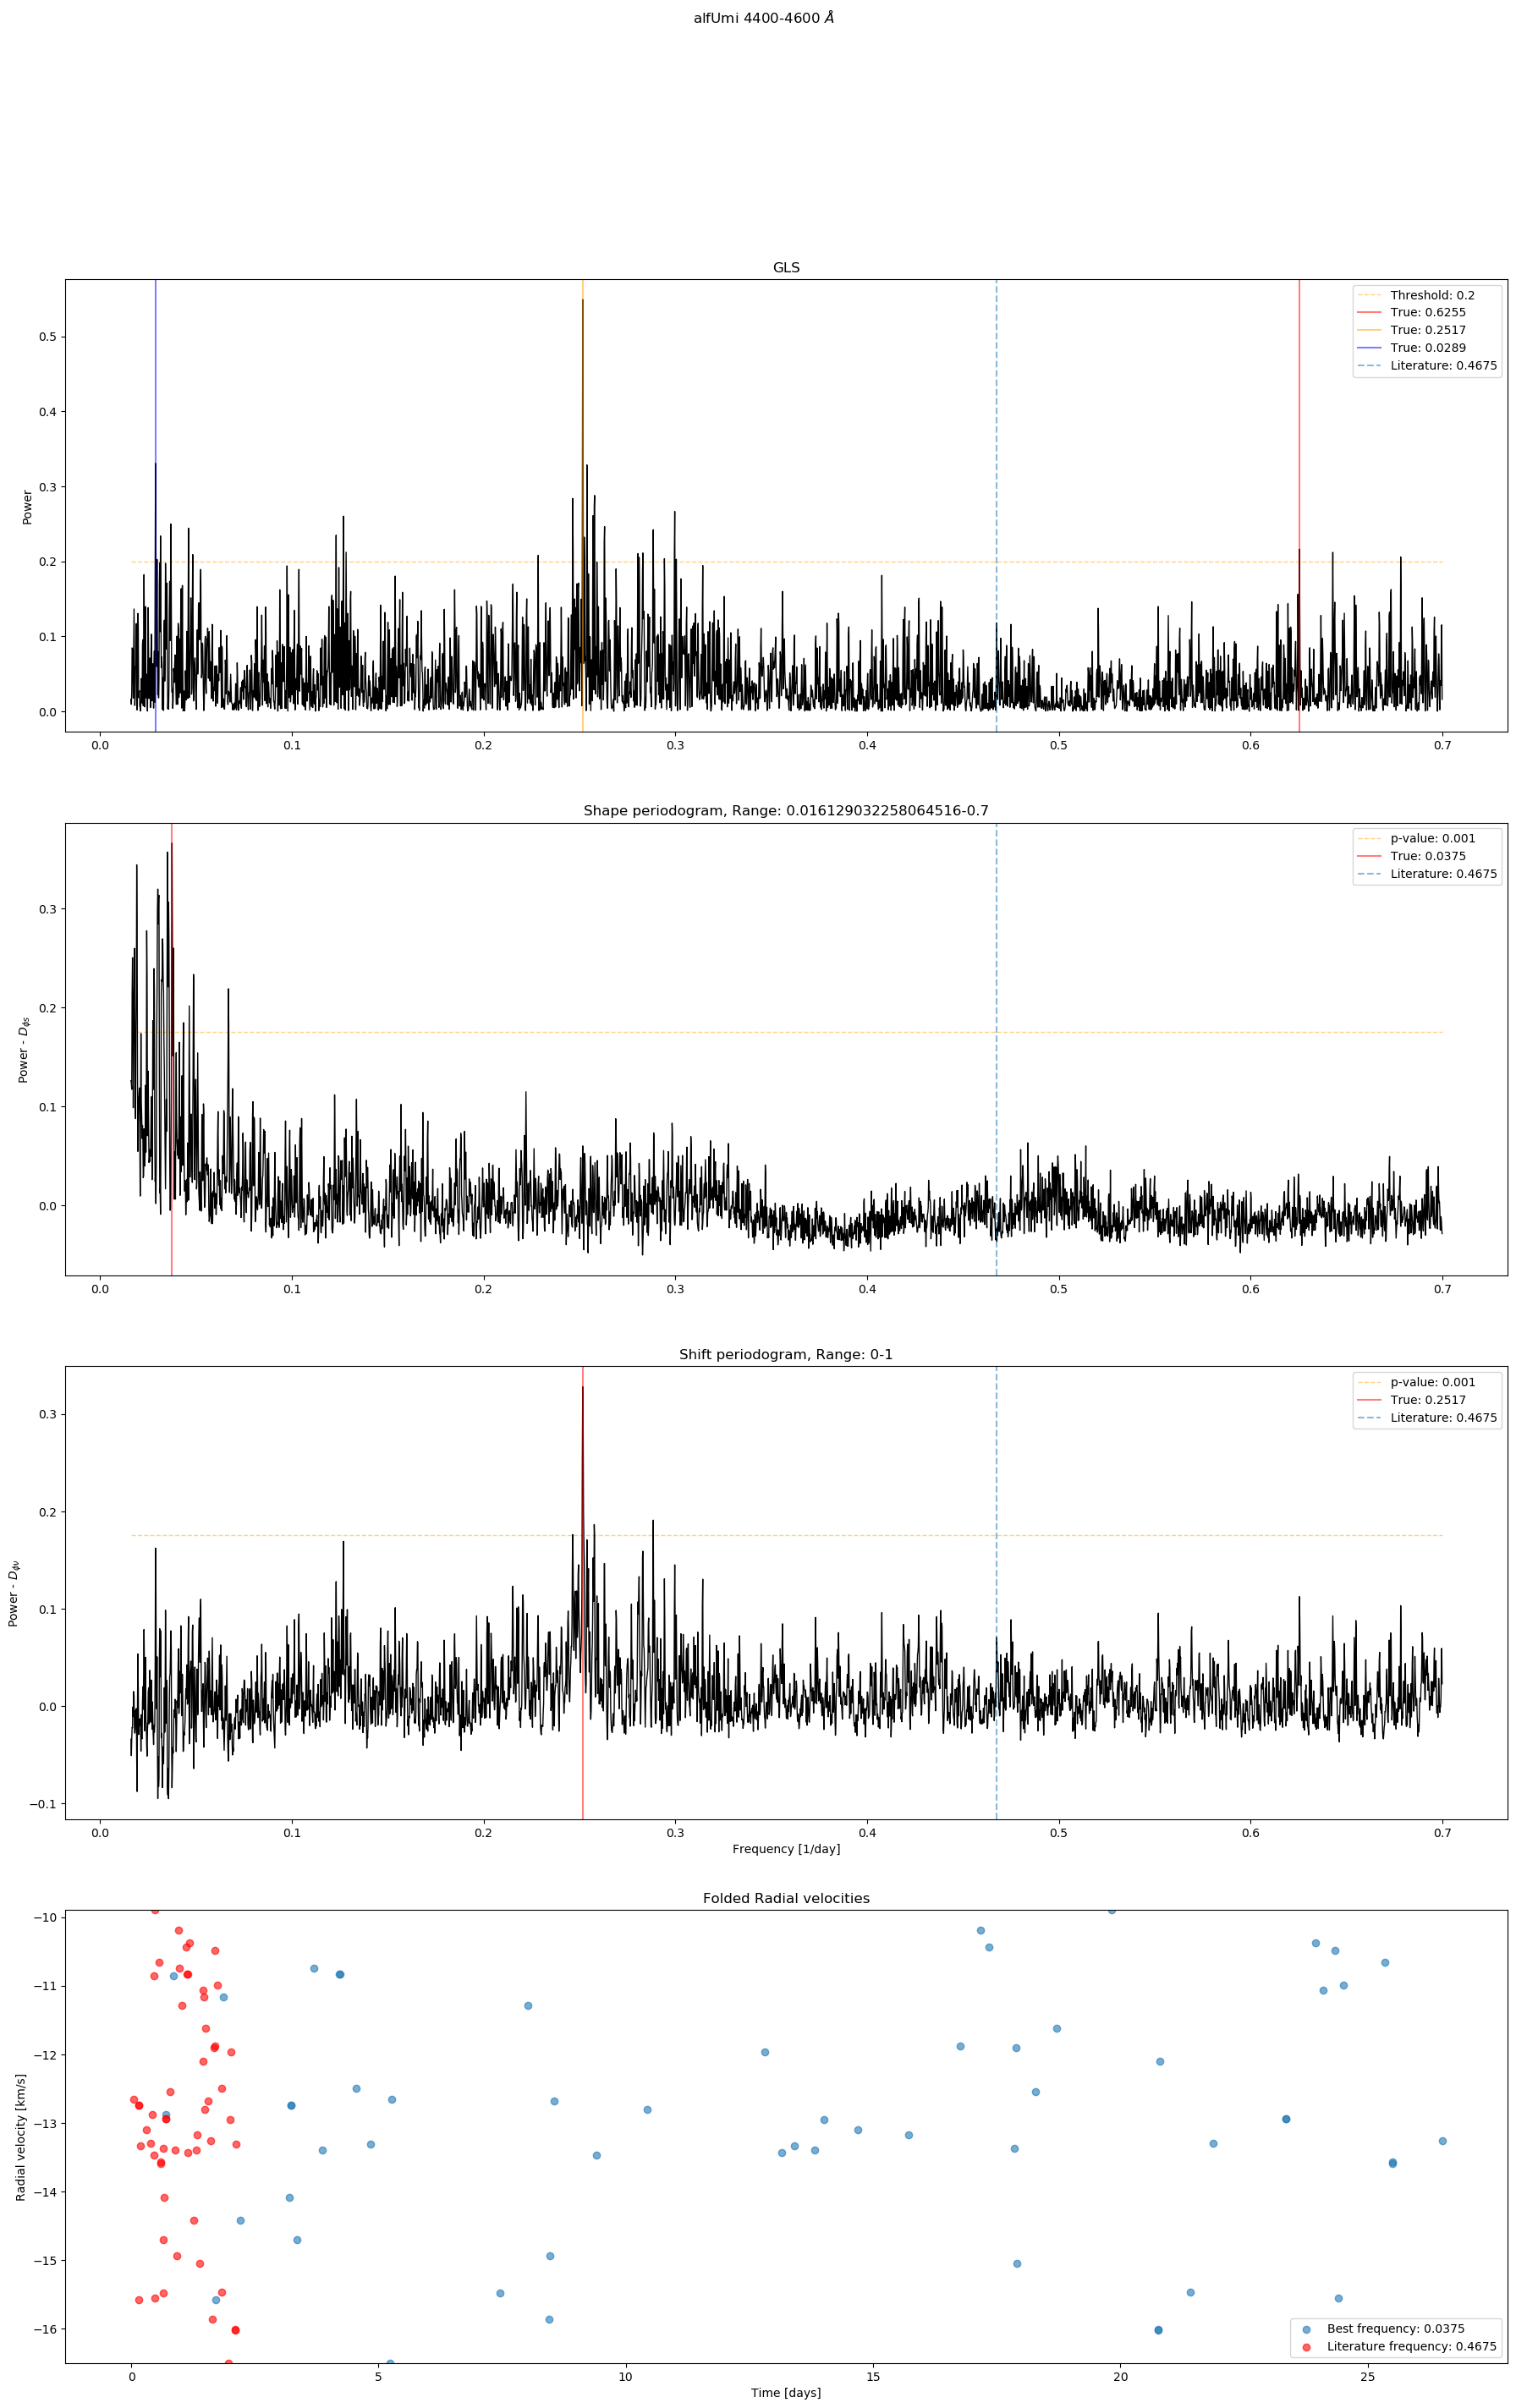

In [32]:
# Plotting the periodograms

obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-3], plot_rv=True,title=r"alfUmi 4400-4600 $\AA$", log_scale=False, plot_peaks=True)

Polaris has its peak in the shift periodogram at 0.2519.